# Data from API

In [1]:
import time
import requests
import pandas as pd

def fetch_vacancies(params, max_pages=20, per_page=100):
    """
    Собирает вакансии с HH.ru по заданным параметрам.
    """
    url = "https://api.hh.ru/vacancies"
    headers = {"User-Agent": "JobAnalysis/1.0 (example@gmail.com)"}
    all_vacancies = []

    print(f"Запуск сбора вакансий с параметрами: {params}")

    for page in range(max_pages):
        params.update({"page": page, "per_page": per_page})
        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            page_data = response.json()

            if "items" in page_data and page_data["items"]:
                all_vacancies.extend(page_data["items"])

            # Логгирование каждых 10 страниц
            if (page + 1) % 10 == 0:
                print(f"Обработано {page + 1} страниц.")

            # Если на странице нет вакансий, завершаем сбор
            if not page_data["items"]:
                print(f"Страница {page} не содержит вакансий. Завершаем сбор.")
                break

        except requests.exceptions.RequestException as e:
            print(f"Ошибка при получении данных с API на странице {page}: {e}")
            break

        # Пауза между запросами, чтобы избежать превышения лимитов API
        time.sleep(1)

    print(f"Всего вакансий собрано: {len(all_vacancies)}.")
    return all_vacancies


params = {
        "text": "Data Scientist OR Machine Learning OR Аналитик данных OR Искусственный интеллект OR Data Engineer OR ML",
        "area": 113,  # Россия
        "specialization": 1,  # IT
        }
raw_api_data = fetch_vacancies(params)

columns = [
    "id", "name", "area_name", "salary_from", "salary_to", "salary_currency",
    "published_at", "employer_name", "alternate_url", "snippet_requirement",
    "snippet_responsibility", "professional_roles", "schedule", "employment", "experience"
]
df = pd.DataFrame(columns=columns)

for i, vacancy in enumerate(raw_api_data):
    salary = vacancy.get("salary", {}) or {}
    employer = vacancy.get("employer", {}) or {}
    snippet = vacancy.get("snippet", {}) or {}
    professional_roles = vacancy.get("professional_roles", []) or []

    data = {
        "id": vacancy.get("id"),
        "name": vacancy.get("name"),
        "area_name": vacancy.get("area", {}).get("name"),
        "salary_from": salary.get("from"),
        "salary_to": salary.get("to"),
        "salary_currency": salary.get("currency"),
        "published_at": vacancy.get("published_at"),
        "employer_name": employer.get("name"),
        "alternate_url": vacancy.get("alternate_url"),
        "snippet_requirement": snippet.get("requirement"),
        "snippet_responsibility": snippet.get("responsibility"),
        "professional_roles": ", ".join([role["name"] for role in professional_roles]),
        "schedule": vacancy.get("schedule", {}).get("name"),
        "employment": vacancy.get("employment", {}).get("name"),
        "experience": vacancy.get("experience", {}).get("name"),
    }

    # Добавляем строку в DataFrame
    df.loc[i] = data

# Вывод первых строк DataFrame
print(df.head())

df.to_csv("data_api.csv")

Запуск сбора вакансий с параметрами: {'text': 'Data Scientist OR Machine Learning OR Аналитик данных OR Искусственный интеллект OR Data Engineer OR ML', 'area': 113, 'specialization': 1}
Обработано 10 страниц.
Обработано 20 страниц.
Всего вакансий собрано: 2000.
          id                                               name area_name  \
0  117951577                Middle Data Scientist / ML Engineer    Москва   
1  116376738                                     Data scientist    Москва   
2  118524897  Junior Data Scientist / Machine Learning Engineer    Москва   
3  116446229                    Data Scientist (Ranking&Search)    Москва   
4  118080934                                     Data Scientist    Москва   

  salary_from salary_to salary_currency              published_at  \
0        None    220000             RUR  2025-03-22T15:02:23+0300   
1        None      None            None  2025-03-22T15:36:14+0300   
2      150000    150000             RUR  2025-03-21T20:14:09+0300  

# EDA

In [2]:
# 1. Первичный осмотр данных
print("Размер данных:", df.shape)
print("Типы данных:")
print(df.dtypes)
print("\nПример данных:")
print(df.head())

# 2. Проверка пропущенных значений
missing_values = df.isnull().sum()
print("\nПропущенные значения:")
print(missing_values)

Размер данных: (2000, 15)
Типы данных:
id                        object
name                      object
area_name                 object
salary_from               object
salary_to                 object
salary_currency           object
published_at              object
employer_name             object
alternate_url             object
snippet_requirement       object
snippet_responsibility    object
professional_roles        object
schedule                  object
employment                object
experience                object
dtype: object

Пример данных:
          id                                               name area_name  \
0  117951577                Middle Data Scientist / ML Engineer    Москва   
1  116376738                                     Data scientist    Москва   
2  118524897  Junior Data Scientist / Machine Learning Engineer    Москва   
3  116446229                    Data Scientist (Ranking&Search)    Москва   
4  118080934                                     Da

In [4]:
# 3. Описательная статистика числовых столбцов
print("\nОписательная статистика числовых данных:")
print(df.describe())


Описательная статистика числовых данных:
               id             name area_name  salary_from  salary_to  \
count        2000             2000      2000          557        342   
unique       1994             1158       103           95         82   
top     117443140  Аналитик данных    Москва       150000     150000   
freq            2              124      1281           61         39   

       salary_currency              published_at employer_name  \
count              648                      2000          2000   
unique               3                      1914          1259   
top                RUR  2025-03-20T11:02:37+0300          СБЕР   
freq               636                         6            69   

                          alternate_url  \
count                              2000   
unique                             1994   
top     https://hh.ru/vacancy/117443140   
freq                                  2   

                                      snippet_requ

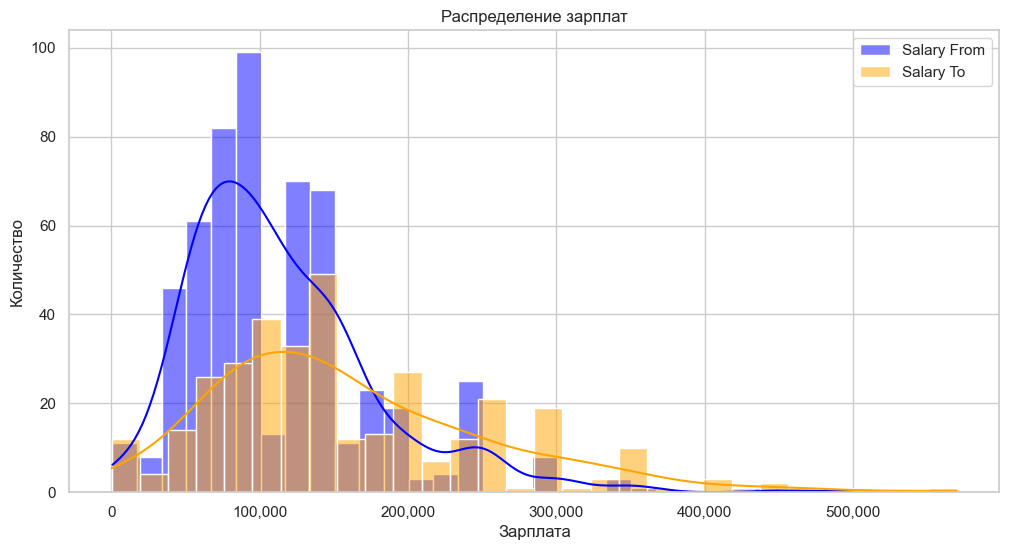

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

sns.set(style="whitegrid")

salary_cols = ['salary_from', 'salary_to']
if all(col in df.columns for col in salary_cols):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['salary_from'], kde=True, bins=30, color='blue', label='Salary From')
    sns.histplot(df['salary_to'], kde=True, bins=30, color='orange', label='Salary To')
    
    # Настройка формата отображения чисел на оси X
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}')) 
    plt.title('Распределение зарплат')
    plt.xlabel('Зарплата')
    plt.ylabel('Количество')
    plt.legend()
    plt.show()
else:
    print("Столбцы salary_from или salary_to отсутствуют в данных.")